In [1]:
from fredapi import Fred
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import glob

In [2]:
from collections import OrderedDict
from pandas.plotting import register_matplotlib_converters
from statsmodels.tsa.stattools import adfuller, kpss, bds
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.stats.diagnostic import het_arch
from statsmodels.graphics.gofplots import qqplot
from scipy.stats import skewtest, kurtosistest, skew, kurtosis, boxcox
from pathlib import Path
import os

In [3]:
import os

os.environ['OMP_NUM_THREADS'] = '1'

In [63]:
from darts import TimeSeries
from darts.utils import statistics
from darts.metrics import mape

In [5]:
fred = Fred(api_key="8ede227d95e33c5cdf2ea8a83577bc0a")

In [6]:
fred_series_ids = ["IHLIDXNSAGB", "IRLTLT01GBM156N", "QGBN628BIS", "UKNGDP", "GBRCPIALLMINMEI"]

In [7]:
fred_series_metadata = []
fred_series_list = []
for series in fred_series_ids:
    metadata = fred.get_series_info(series)
    series = fred.get_series(series).rename(metadata["title"])
    fred_series_metadata.append(metadata)
    fred_series_list.append(series)

In [8]:
economic_uncertainty = pd.read_csv("../data/UK_Daily_Policy_Data.csv")

In [9]:
economic_uncertainty["date"] = pd.to_datetime(economic_uncertainty.drop("daily_policy_index", axis=1))
economic_uncertainty = economic_uncertainty.drop(["day", "month", "year"], axis=1).set_index("date").squeeze()

In [10]:
data = fred_series_list.copy()
data.append(economic_uncertainty)

In [11]:
data_ts = [TimeSeries.from_series(series) for series in data]

In [12]:
[print(str(idx) + " " + series.title) for idx, series in enumerate(fred_series_metadata)]
print(str(len(data_ts) - 1) + " " + "UK_Daily_Policy_Data")

0 Job Postings on Indeed in the United Kingdom
1 Interest Rates: Long-Term Government Bond Yields: 10-Year: Main (Including Benchmark) for United Kingdom
2 Residential Property Prices for United Kingdom
3 Gross Domestic Product for United Kingdom
4 Consumer Price Indices (CPIs, HICPs), COICOP 1999: Consumer Price Index: Total for United Kingdom
5 UK_Daily_Policy_Data


In [13]:
series = data_ts[5]

In [14]:
splitting = 0.95
visualizing = 0.9

In [15]:
from darts.dataprocessing.transformers import Scaler

In [16]:
train, val = series.split_before(splitting)

In [17]:
import torch
for i in range(torch.cuda.device_count()):
   print(torch.cuda.get_device_properties(i).name)
torch.set_float32_matmul_precision('high')

NVIDIA GeForce RTX 5070 Ti


In [43]:
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from pytorch_lightning.callbacks import Callback

In [48]:
class LossRecorder(Callback):
    def __init__(self):
        self.train_loss_history = []
        self.val_loss_history = []

    def on_train_epoch_end(self, trainer, pl_module):
        self.train_loss_history.append(trainer.callback_metrics["train_loss"].item())
        self.val_loss_history.append(trainer.callback_metrics["val_loss"].item())


In [45]:
loss_recorder = LossRecorder()

# stop training when validation loss does not decrease more than 0.05 (`min_delta`) over
# a period of 5 epochs (`patience`)
early_stopper = EarlyStopping(
    monitor="val_loss",
    patience=5,
    min_delta=0.05,
    mode='min',
)

pl_trainer_kwargs={"callbacks": [early_stopper, loss_recorder]}

In [46]:
# https://unit8co.github.io/darts/generated_api/darts.models.forecasting.nbeats.html
from darts.models import NBEATSModel
nbeats_model = NBEATSModel(
    input_chunk_length=24, 
    output_chunk_length=12, 
    n_epochs=100, 
    random_state=0, 
    model_name="NBEATS",
    log_tensorboard=True,
    pl_trainer_kwargs=pl_trainer_kwargs
)
nbeats_model.fit(train, val_series=val, verbose=True)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | stacks          | ModuleList       | 6.2 M  | train
-------------------------------------------------------------
6.2 M     Trainable params
1.4 K     Non-trainable params
6.2 M     Total params
24.787    Total estimated model params size (MB)
396       Modules in train mode
0         Modules in eval mode


Sanity Checking: |                                                                               | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

NBEATSModel(output_chunk_shift=0, generic_architecture=True, num_stacks=30, num_blocks=1, num_layers=4, layer_widths=256, expansion_coefficient_dim=5, trend_polynomial_degree=2, dropout=0.0, activation=ReLU, input_chunk_length=24, output_chunk_length=12, n_epochs=100, random_state=0, model_name=NBEATS, log_tensorboard=True, pl_trainer_kwargs={'callbacks': [<pytorch_lightning.callbacks.early_stopping.EarlyStopping object at 0x0000021E2D2D5C00>, <__main__.LossRecorder object at 0x0000021E2D2D4D00>]})

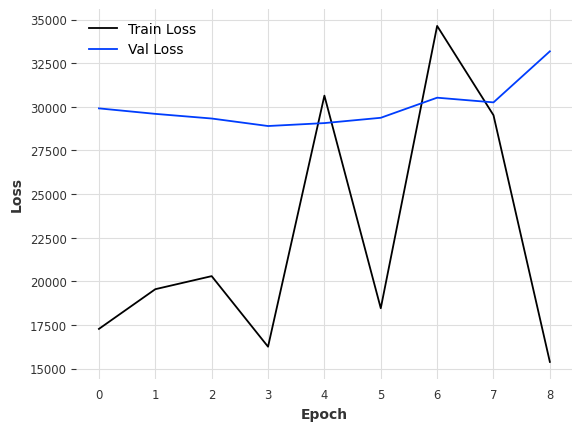

In [47]:
plt.plot(loss_recorder.train_loss_history, label='Train Loss')
plt.plot(loss_recorder.val_loss_history, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [20]:
val_preds = nbeats_model.predict(len(val))

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |                                                                                    | 0/? [00:00<…

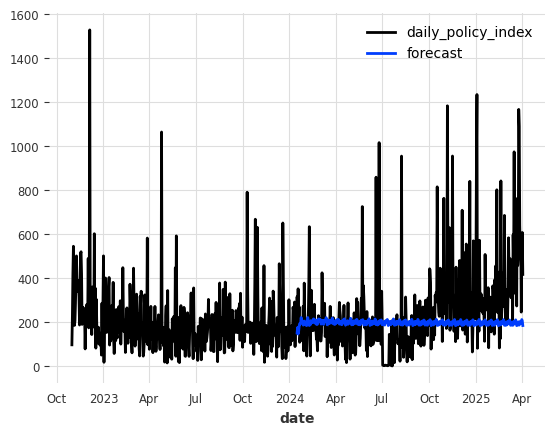

In [21]:
series.drop_before(visualizing).plot()
val_preds.plot(label="forecast", low_quantile=0.05, high_quantile=0.95)
plt.legend()
plt.show()

In [49]:
loss_recorder = LossRecorder()
# stop training when validation loss does not decrease more than 0.05 (`min_delta`) over
# a period of 5 epochs (`patience`)
early_stopper = EarlyStopping(
    monitor="val_loss",
    patience=5,
    min_delta=0.05,
    mode='min',
)

pl_trainer_kwargs={"callbacks": [early_stopper, loss_recorder]}

In [50]:
from darts.models import RNNModel, BlockRNNModel

pl_trainer_kwargs={"callbacks": [early_stopper]}
lstm_model = RNNModel(
    model="LSTM",
    hidden_dim=20,
    # n_rnn_layers=3,
    dropout=0,
    batch_size=32,
    n_epochs=100,
    optimizer_kwargs={"lr": 1e-3},
    model_name="LSTM",
    log_tensorboard=True,
    random_state=7,
    training_length=180,
    input_chunk_length=60,
    # output_chunk_length=12,
    force_reset=True,
    save_checkpoints=True,
    pl_trainer_kwargs=pl_trainer_kwargs,
)


In [51]:
lstm_model.fit(train, val_series=val, verbose=True)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 1.8 K  | train
6 | V               | Linear           | 21     | train
-------------------------------------------------------------
1.9 K     Trainable params
0         Non-trainable params
1.9 K     Total params
0.007     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode


Sanity Checking: |                                                                               | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

RNNModel(model=LSTM, hidden_dim=20, n_rnn_layers=1, dropout=0, training_length=180, batch_size=32, n_epochs=100, optimizer_kwargs={'lr': 0.001}, model_name=LSTM, log_tensorboard=True, random_state=7, input_chunk_length=60, force_reset=True, save_checkpoints=True, pl_trainer_kwargs={'callbacks': [<pytorch_lightning.callbacks.early_stopping.EarlyStopping object at 0x0000021E402AE200>]})

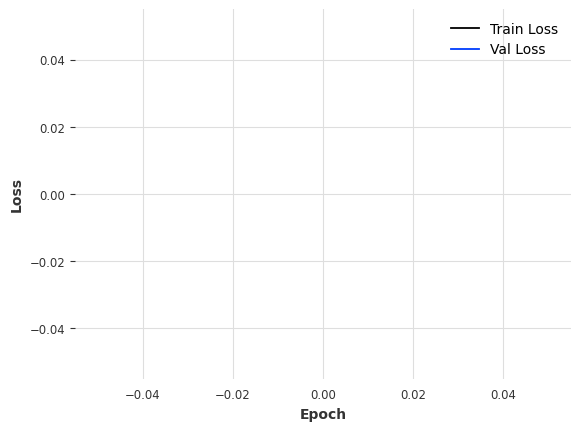

In [61]:
plt.plot(loss_recorder.train_loss_history, label='Train Loss')
plt.plot(loss_recorder.val_loss_history, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [53]:
lstm_model.load_from_checkpoint("LSTM", best=True)

RNNModel(model=LSTM, hidden_dim=20, n_rnn_layers=1, dropout=0, training_length=180, batch_size=32, n_epochs=100, optimizer_kwargs={'lr': 0.001}, model_name=LSTM, log_tensorboard=True, random_state=7, input_chunk_length=60, force_reset=True, save_checkpoints=True, pl_trainer_kwargs={'callbacks': [<pytorch_lightning.callbacks.early_stopping.EarlyStopping object at 0x0000021E2D782C80>]})

In [54]:
val_preds = lstm_model.predict(len(val))

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |                                                                                    | 0/? [00:00<…

In [55]:
val_preds

<TimeSeries (DataArray) (date: 444, component: 1, sample: 1)> Size: 4kB
array([[[177.40118691]],

       [[181.82924197]],

       [[182.04748886]],

       [[182.65916263]],

       [[183.15963579]],

       [[183.6008027 ]],

       [[183.98957308]],

       [[184.34222069]],

       [[184.66940287]],

       [[184.97975161]],

...

       [[304.62057715]],

       [[304.62057715]],

       [[304.62057715]],

       [[304.62057715]],

       [[304.62057715]],

       [[304.62057715]],

       [[304.62057715]],

       [[304.62057715]],

       [[304.62057715]],

       [[304.62057715]]])
Coordinates:
  * date       (date) datetime64[ns] 4kB 2024-01-16 2024-01-17 ... 2025-04-03
  * component  (component) object 8B 'daily_policy_index'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  None
    hierarchy:          None
    metadata:           None

In [56]:
lstm_model.first_prediction_index

0

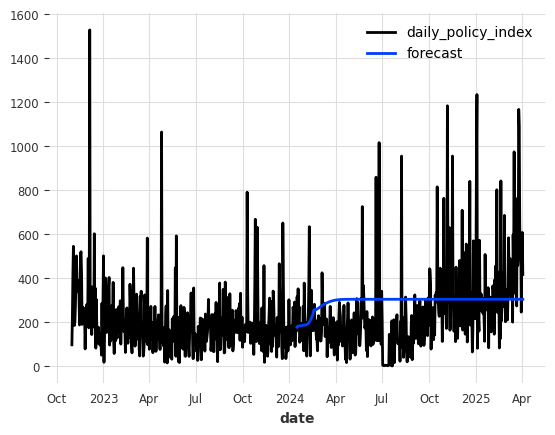

In [57]:
series.drop_before(visualizing).plot()
val_preds.plot(label="forecast", low_quantile=0.05, high_quantile=0.95)
plt.legend()
plt.show()

# Backtesting NNs

In [67]:
def backtest_models(series: TimeSeries, models: list, horizons: list=[1, 3, 7], points_to_test: int=100, verbose=True):
    backtest_results = dict()
    for horizon in sorted(horizons):
        backtests = [model.historical_forecasts(
            series,
            start=len(series) - points_to_test,
            forecast_horizon=horizon,
            retrain=False,
            verbose=verbose,
        ) for model in models]
        backtest_results[horizon] = {str(model.model_name): (backtests[i], mape(backtests[i], series)) for i, model in enumerate(models)}
    return backtest_results

In [68]:
def plot_backtest_results(series: TimeSeries, backtest_results: dict, points_to_test: int=100):
    for horizon, model in backtest_results.items():
        series.drop_before(len(series) - 2*points_to_test).plot(label='data')
        for model_name, (backtest, mape) in model.items():
            backtest.plot(lw=3, label=f'{model_name}, MAPE={mape:.2f}%')
        plt.title(f'Backtests with {horizon} {series.freq} forecast horizon')
        plt.legend()
        plt.show()

In [69]:
models = [nbeats_model, lstm_model]

In [70]:
results = backtest_models(series, models=models)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |                                                                                    | 0/? [00:00<…

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |                                                                                    | 0/? [00:00<…

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |                                                                                    | 0/? [00:00<…

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |                                                                                    | 0/? [00:00<…

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |                                                                                    | 0/? [00:00<…

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |                                                                                    | 0/? [00:00<…

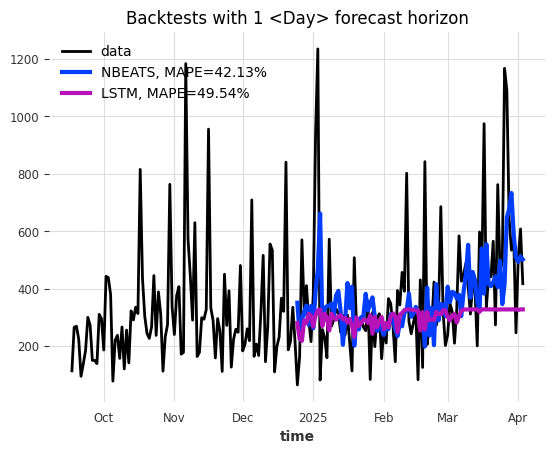

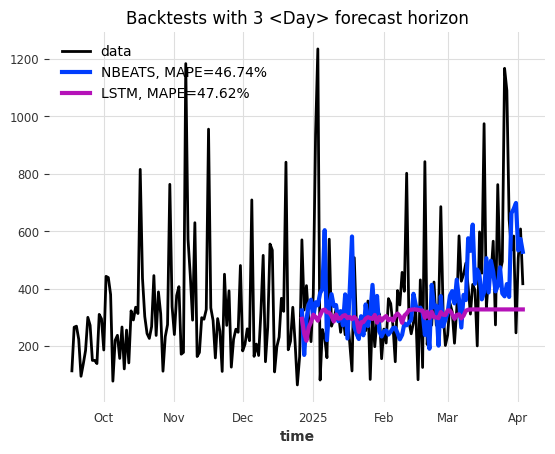

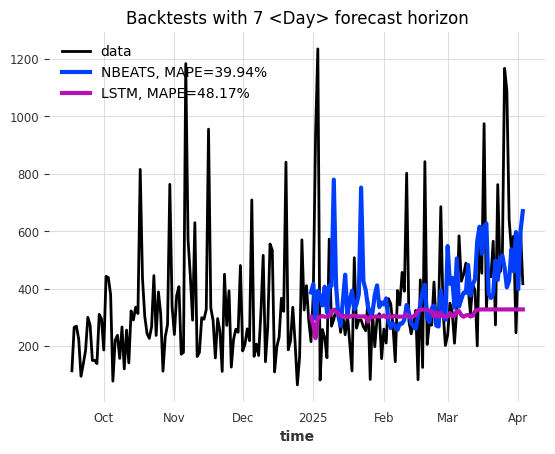

In [71]:
plot_backtest_results(series, results)